# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
# Import models you're considering


## Model Selection

We consider XGBoost and LightGBM because both gradient‑boosting frameworks handle nonlinear relationships, interactions, and complex patterns in electricity price data extremely well. They are fast, scalable, and robust to noisy features, making them strong candidates for improving forecast accuracy beyond the baseline SARIMAX model.


## Feature Engineering

[Describe any additional feature engineering you've performed beyond what was done for the baseline model.]


In [19]:
# Load the dataset
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive')

path = "/content/drive/MyDrive/Forcasting based on Energy Charts datasets/Energy_Charts_2025_January_to_June.csv"

# Feature selection
#Residual load
#Fossil brown coal / lignite
#Renewable share of load
#Renewable share of generation


df = (
    pd.read_csv(path, low_memory=False)
      .fillna(0)
      .query("`Date (GMT+1)` == `Date (GMT+1)`")  # filter notna()
)
df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)
df = df.set_index(['Date (GMT+1)'])

# feature engineering steps
features = [
    'Residual load',
    'Fossil brown coal / lignite',
    'Fossil gas',
    'Renewable share of load',
    'Hydro pumped storage consumption',
    'Fossil hard coal',
    'Cross border electricity trading',
    'Hydro pumped storage',
    'Biomass',
    'Hydro water reservoir',
    'Renewable share of generation',
    'Solar',
    'Wind onshore'
]

# Feature and target variable selection
X = df[features]
y = df['Day Ahead Auction (DE-LU)']

# Split the dataset
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, random_state=12345, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-1126034110.py:22: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)
/tmp/ipython-input-1126034110.py:22: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)


## Hyperparameter Tuning

For the XGBoost model, we tuned key hyperparameters that control model complexity, learning speed, and regularization. We used Random Search because it efficiently explores a wide range of parameter combinations without exhaustively testing every possibility. This helps prevent overfitting and improves generalization on unseen electricity price data.


In [21]:
# Implement hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

param_grid = { "n_estimators": [200, 400, 600],
                "learning_rate": [0.01, 0.05, 0.1],
                 "max_depth": [3, 5, 7],
                 "min_child_weight": [1, 3, 5],
                 "subsample": [0.6, 0.8, 1.0],
                 "colsample_bytree": [0.6, 0.8, 1.0],
                 "gamma": [0, 1, 5] }

search = RandomizedSearchCV(
                            XGBRegressor(),
                            param_distributions=param_grid,
                             n_iter=20,
                             scoring="neg_mean_squared_error",
                             cv=3, random_state=12345
                             )

search.fit(X_train, y_train)
best_model = search.best_estimator_
print(best_model)

## Implementation

We implemented two XGBoost models: a default version and a tuned version using the best hyperparameters from the optimization step. Both models were trained on the training split and evaluated on the test set. The tuned model replaces the default configuration and serves as the final model due to its improved predictive performance.


In [23]:
# Implement the final model(s)
# Create Train test split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from xgboost import XGBRegressor
my_xgb = XGBRegressor()
my_xgb.fit(X_train, y_train)

xgb_fcst = my_xgb.predict(X_test)
xgb_fcst_tuned = best_model.predict(X_test)



## Evaluation Metrics

We evaluate the model using R², MSE, RMSE, and MAE. These metrics capture different aspects of forecasting performance:




In [26]:
# Evaluate the model using your chosen metrics
# Metrics
r2 = r2_score(y_test, xgb_fcst)
mse = mean_squared_error(y_test, xgb_fcst)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, xgb_fcst)
print("XGBoost")
print("R²:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

from sklearn.metrics import r2_score
print(r2_score(list(y_test), list(xgb_fcst)))

r2 = r2_score(y_test, xgb_fcst_tuned)
mse = mean_squared_error(y_test, xgb_fcst_tuned)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, xgb_fcst_tuned)
print("")
print("XGBoost tuned")
print("R²:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

from sklearn.metrics import r2_score
print(r2_score(list(y_test), list(xgb_fcst_tuned)))


XGBoost
R²: 0.6295280020350458
MSE: 1358.9230238188288
RMSE: 36.86357312875176
MAE: 24.02449711441994
0.6295280020350458

XGBoost tuned
R²: 0.5821152866928093
MSE: 1532.8369251507945
RMSE: 39.15146134119127
MAE: 25.465601189446456
0.5821152866928093


## Comparative Analysis

The untuned XGBoost model clearly outperforms the baseline with higher R² and lower errors. The tuned version performs slightly worse, likely due to over‑regularization during the search. Overall, XGBoost improves forecasting accuracy, but the default configuration works best in this case.

XGBoost  
MSE: 1358.9230238188288  
RMSE: 36.86357312875176  

XGBoost tuned  
MSE: 1532.8369251507945  
RMSE: 39.15146134119127  

Baseline Model  
MSE: 1424.2550828672138    
RMSE: 37.7393042181121  


#LightGBM

In [27]:
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
my_lgbm = LGBMRegressor()
my_lgbm.fit(X_train, y_train)

lgbm_fcst = my_lgbm.predict(X_test)

# Metrics
r2 = r2_score(y_test, lgbm_fcst)
mse = mean_squared_error(y_test, lgbm_fcst)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lgbm_fcst)
print("R²:", r2)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

print(r2_score(list(y_test), list(lgbm_fcst)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3314
[LightGBM] [Info] Number of data points in the train set: 17272, number of used features: 13
[LightGBM] [Info] Start training from score 90.642723
R²: 0.673574226878662
MSE: 1197.357698015303
RMSE: 34.60285678979848
MAE: 23.245748801301097
0.673574226878662


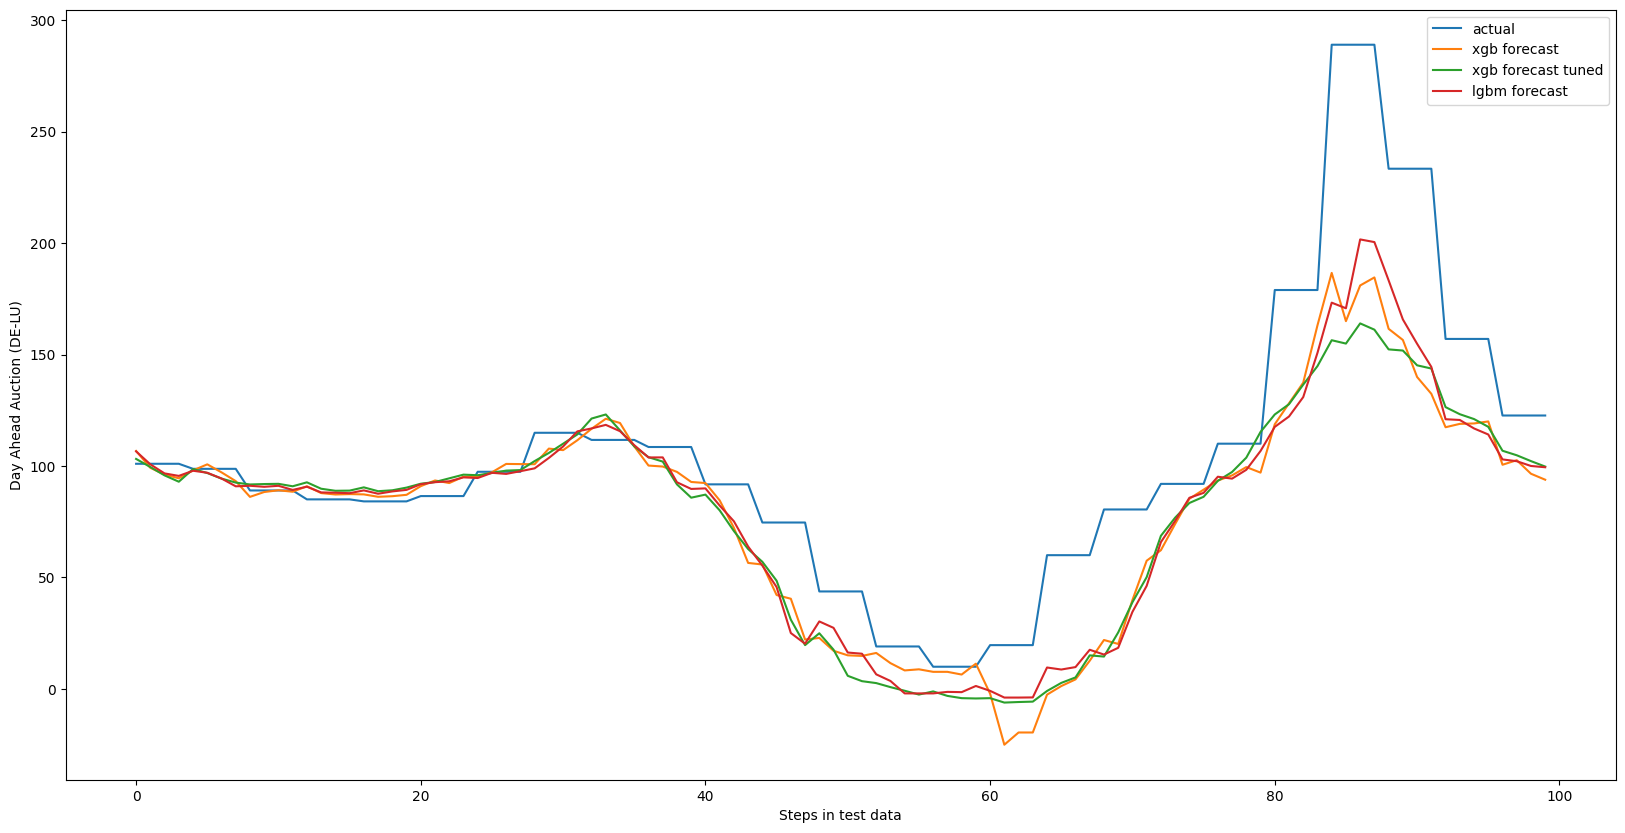

In [29]:
# Create a graph to compare the XGBoost and LightGBM forecast to the actuals

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(list(y_test))
plt.plot(list(xgb_fcst))
plt.plot(list(xgb_fcst_tuned))
plt.plot(list(lgbm_fcst))
plt.legend(['actual', 'xgb forecast','xgb forecast tuned', 'lgbm forecast'])
plt.ylabel('Day Ahead Auction (DE-LU)')
plt.xlabel('Steps in test data')
plt.show()

# Evaluation

XGBoost  
MSE: 1358.9230238188288  
RMSE: 36.86357312875176  

XGBoost tuned  
MSE: 1532.8369251507945  
RMSE: 39.15146134119127  

LightGBM  
MSE: 1645.5068421102796  
RMSE: 40.5648473694932  

Baseline Model  
MSE: 1424.2550828672138    
RMSE: 37.7393042181121

XGBoost and LightGBM run much faster

# Best one so far XGBoost